In [1]:
using Gen
using Distributions
import JSON


In [2]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end

logmeanexp (generic function with 1 method)

Gen programs typically consist of a combination of (i) probabilistic models written in modeling languages and (ii) inference programs written in regular Julia code. Gen provides a built-in modeling language that is itself based on Julia.

In [3]:
import Gen.logpdf
import Gen.has_output_grad
import Gen.has_argument_grads
import Gen.random
import SpecialFunctions.lbeta

In [4]:
struct DirichletDistribution <: Gen.Distribution{Vector{Float64}} end
const dirichletDistribution = DirichletDistribution()

function logpdf(::DirichletDistribution, x::AbstractVector{U}, theta::AbstractVector{T}) where {U,T}
    Distributions.logpdf(Distributions.Dirichlet(theta),x)
end

function random(::DirichletDistribution, theta::AbstractVector{T}) where {T}
    rand(Distributions.Dirichlet(theta))
end

(::DirichletDistribution)(theta) = random(DirichletDistribution(), theta)

has_output_grad(::DirichletDistribution) = false
has_argument_grads(::DirichletDistribution) = false

has_argument_grads (generic function with 19 methods)

In [30]:
# doc_lengths: a list, specifying the length of each input document
# num_senses : the number of latent senses
# alpha : param of the dirichlet distribution over document senses (a sample from dirichlet beta is a document mixture)
# beta : param of the dirichlet distribution over vocab (a sample from dirichlet(alpha) is a sense)
@gen function lda(num_senses::Int,doc_lengths::Vector{Int},a::Float64,b::Float64,vocab_size::Int)
        
    num_docs = length(doc_lengths)
    max_doc_length = maximum(doc_lengths)
    
    senses = Array{Float64,2}(undef,num_senses,vocab_size)
#     print("making senses\n")
    for i in range(1,stop=num_senses)
#         print(senses[i])
#         print("make sense ",i,"\n")
        senses[i,:] = @trace(dirichletDistribution(b*ones(vocab_size)), :sense => i)
    end
#     print("made senses\n")
#     data = Array{Float64,2}(undef,num_docs,max_doc_length)
#     print("making docs\n")
    for (i,doc_length) in enumerate(doc_lengths)
#         print("make mixture ",i,"\n")
        theta = @trace(dirichletDistribution(a*ones(num_senses)),:mixture => i)

#         print("making words\n")
        for j in range(1,stop=doc_length)
#             print("choose sense ",i," ", j,"\n")
            sense = @trace(categorical(theta),:doc_sense => i => j)
#             print("sense is ", sense,"\n")
#             print("choose word ",i," ",j,"\n")
#             print("senses",senses)
#             print(senses[sense,:],"SENSE")
            d = senses[sense,:]
            word = @trace(categorical(d),:word => i => j)
#             print("chosen word ",word,"\n")
#             data[i,j]=Int(sense)
        end
    end
                
    return senses

end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Int64, Array{Int64,1}, Float64, Float64, Int64], ##lda#366, Bool[false, false, false, false, false], false)

In [112]:

# MAKE CONSTRAINT CHOICEMAP
function make_constraints(data)

    constraints = Gen.choicemap()
        for (i, x) in enumerate(data)
            for (j,y) in enumerate(x)
                constraints[:word => i => j] = data[i][j]
            end
        end
    constraints
end

make_constraints (generic function with 1 method)

In [158]:
function load_phrase_data(phrase)

    id2token = open("/Users/reuben/Dropbox/Reuben/Work/Stanford/Classes/229/project/code/phrases/"*phrase*"_id2token.json") do file
        f = read(file, String)
        global parsed_id2token = JSON.parse(f)  
    end

    data = open("/Users/reuben/Dropbox/Reuben/Work/Stanford/Classes/229/project/code/phrases/"*phrase*"_corpus.json") do file
        f = read(file, String)
        global parsed_data = JSON.parse(f)  
    end

    indices = open("/Users/reuben/Dropbox/Reuben/Work/Stanford/Classes/229/project/code/phrases/"*phrase*"_indices.json") do file
        f = read(file, String)
        global parsed_indices = JSON.parse(f)  
    end
    
    
    phrase_data = data[1:indices[1]]
    word1_data = data[indices[1]:indices[2]][1:100]
    word2_data = data[indices[2]:length(data)][1:100]
    
    return (phrase_data,word1_data,word2_data,id2token)
    
end

load_phrase_data (generic function with 1 method)

In [160]:
# (phrase_data,word1_data,word2_data,id2token) = load_phrase_data("cold shoulder")

In [11]:
# MCMC
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
 
    (num_senses,doc_lengths,a,b,vocab_size) = get_args(tr)
    for i=1:length(doc_lengths)
        (tr, _) = mh(tr, select(:mixture => i,[:doc_sense => i => j for j=1:doc_lengths[i]]))

    end
    
    for i=1:num_senses
        (tr, _) = mh(tr, select(:sense => i))
    end
    
    tr
end;

function block_resimulation_inference(inputs, data)
    observations = make_constraints(data)
    print("made constraints\n")
    (tr, _) = generate(lda, inputs, observations)
    print("made initial trace\n")
    for iter=1:20
        print("iter",iter)
        tr = block_resimulation_update(tr)
    end
    tr
end;

In [224]:
# TOY DATASET
toy_data = [[2,2,2,2,2,2,2,2],[1,1,1,1,1,1,1]]


num_senses = 2
doc_lengths = [length(doc) for doc in toy_data]
a=1
b=1

vocab_size = 2
print(vocab_size)

# trace = simulate(lda,(num_senses,doc_lengths,a,b,vocab_size))

inputs = (num_senses,doc_lengths,a,b,vocab_size)

# observations = make_constraints(toy_data)
# (tr, _) = generate(lda, inputs, observations)
# block_resimulation_update(tr)
# print(trace)
# print(get_choices(trace))
tr = block_resimulation_inference(inputs,toy_data)
print(get_choices(tr))

2made constraints
made initial trace
iter1iter2iter3iter4iter5iter6iter7iter8iter9iter10iter11iter12iter13iter14iter15iter16iter17iter18iter19iter20│
├── :sense
│   │
│   ├── 2 : [0.460774, 0.539226]
│   │
│   └── 1 : [0.776791, 0.223209]
│
├── :word
│   │
│   ├── 2
│   │   │
│   │   ├── 7 : 1
│   │   │
│   │   ├── 4 : 1
│   │   │
│   │   ├── 2 : 1
│   │   │
│   │   ├── 3 : 1
│   │   │
│   │   ├── 5 : 1
│   │   │
│   │   ├── 6 : 1
│   │   │
│   │   └── 1 : 1
│   │
│   └── 1
│       │
│       ├── 7 : 2
│       │
│       ├── 4 : 2
│       │
│       ├── 2 : 2
│       │
│       ├── 3 : 2
│       │
│       ├── 5 : 2
│       │
│       ├── 8 : 2
│       │
│       ├── 6 : 2
│       │
│       └── 1 : 2
│
├── :mixture
│   │
│   ├── 2 : [0.62554, 0.37446]
│   │
│   └── 1 : [0.664794, 0.335206]
│
└── :doc_sense
    │
    ├── 2
    │   │
    │   ├── 7 : 2
    │   │
    │   ├── 4 : 1
    │   │
    │   ├── 2 : 1
    │   │
    │   ├── 3 : 1
    │   │
    │   ├── 5 : 1
    │   │
    │   ├── 6 : 1
    │

In [19]:
a = lda(num_senses,doc_lengths,a,b,vocab_size)

([6.0 1.0 … 8.0 6.0; 4.0 4.0 … 7.0 2.72578e-314], [0.640685 0.359315; 0.0171126 0.982887; … ; 0.825057 0.174943; 0.111137 0.888863])

In [225]:
short_data = data[1:100]
num_senses = 2
doc_lengths = [length(doc) for doc in short_data]
a=1
b=1

keys = [parse(Int,x[1]) for x in id2token]
# print(keys)
vocab_size = maximum(keys)

inputs = (num_senses,doc_lengths,a,b,vocab_size)

# observations = make_constraints(short_data)

# (tr, _) = importance_resampling(lda, inputs, observations, 10)

# (tr, _) = generate(lda, inputs, observations)
# tr = block_resimulation_update(tr)

# get_args(tr)
# trace = simulate(lda,inputs)



tr = block_resimulation_inference(inputs,data)
print(get_choices(tr))

made constraints
made initial trace
iter1iter2iter3iter4iter5iter6iter7iter8iter9iter10iter11iter12iter13iter14iter15iter16iter17iter18iter19iter20│
├── :sense
│   │
│   ├── 2 : [8.77798e-5, 2.19465e-5, 8.21983e-6, 4.83742e-5, 0.000174515, 6.24994e-6, 9.10435e-5, 0.000115786, 2.07285e-5, 3.06573e-5, 0.000181877, 0.000103407, 8.4013e-7, 0.000254406, 1.58918e-5, 0.000150626, 0.000105905, 5.4932e-5, 0.000374773, 1.53227e-5, 0.000179926, 0.00015401, 5.78109e-5, 6.48722e-5, 0.00033293, 4.44692e-5, 0.000202942, 4.53878e-5, 0.00021028, 0.000101761, 7.96285e-5, 2.71797e-5, 0.000180156, 0.000103618, 9.48704e-5, 1.23281e-5, 6.21077e-5, 0.000145953, 0.000248171, 0.000279454, 9.31211e-5, 0.000240957, 0.000222262, 0.000103636, 0.000368641, 0.00022085, 1.50502e-5, 8.76762e-5, 0.000385799, 0.000231883, 0.000260034, 7.83214e-6, 3.57499e-5, 2.92804e-5, 0.000540215, 2.50141e-5, 0.000186666, 9.98544e-5, 0.000413085, 5.54395e-5, 0.000298049, 0.000123201, 0.000543863, 0.000158437, 0.000178839, 0.000326228,

│   └── 1 : [0.000316897, 9.90891e-6, 0.000200066, 5.61068e-5, 0.000192902, 0.000209843, 2.19451e-5, 0.000258406, 1.68508e-5, 4.16653e-5, 0.00010675, 1.73657e-5, 0.000248588, 7.48088e-5, 0.000187694, 0.000178734, 0.000128424, 2.60304e-5, 0.000581409, 8.00766e-5, 9.88496e-5, 0.000166039, 1.87069e-5, 0.000172713, 0.000161642, 3.01555e-5, 0.000144788, 0.000402912, 0.000137945, 5.94747e-5, 8.33362e-5, 6.4379e-5, 0.000130298, 0.000199249, 7.36877e-7, 0.000194103, 1.29032e-6, 0.000280314, 0.000136342, 0.000132301, 0.000293117, 0.000121167, 3.55551e-5, 0.000240376, 0.000204338, 0.000249241, 0.00016027, 6.80163e-5, 2.54902e-5, 9.20047e-5, 0.000192052, 4.68891e-6, 0.00025575, 6.83521e-5, 0.000384976, 3.67307e-5, 4.1928e-5, 0.000136216, 2.96187e-5, 7.71745e-5, 2.42752e-6, 4.24994e-5, 0.000246456, 7.86787e-5, 0.0003494, 4.58442e-5, 2.83472e-5, 4.02492e-5, 0.000153668, 0.000273083, 1.99396e-5, 5.48454e-5, 5.78194e-5, 9.88051e-5, 4.67915e-6, 5.14102e-5, 0.000212905, 0.000324021, 0.000195564, 0.0002

.13306e-5, 0.000347192, 6.06205e-6, 0.000211676, 6.72193e-6, 7.89567e-6, 4.22433e-6, 2.10135e-5, 0.000200807, 7.23132e-5, 3.18705e-5, 1.89268e-5, 0.000265882, 0.000156192, 0.000178365, 9.11965e-5, 0.000510662, 0.000159441, 0.000191216, 2.75127e-7, 0.000374867, 0.000149899, 6.68053e-5, 0.000182951, 1.29977e-5, 0.000137793, 5.71519e-5, 4.42348e-5, 5.08382e-5, 0.000169223, 0.000164047, 0.000142785, 2.5632e-5, 0.000278239, 4.68573e-5, 0.000229388, 0.00023813, 9.64687e-5, 4.53621e-6, 0.000101664, 7.90889e-6, 0.000148335, 4.09335e-5, 0.000373803, 2.40352e-6, 7.9281e-5, 8.49725e-6, 1.38026e-5, 0.000499569, 0.000128631, 1.85116e-5, 4.3374e-5, 1.03347e-5, 0.000194695, 0.000131576, 0.000145794, 0.000283559, 0.000251111, 0.000182086, 1.82885e-5, 2.99666e-5, 0.000174392, 1.05817e-5, 0.000158992, 8.05194e-5, 5.23087e-5, 0.000330456, 0.000349796, 0.000240722, 8.22545e-6, 0.000143005, 0.000110569, 9.06521e-5, 3.93106e-5, 2.0974e-5, 0.00010016, 0.000395635, 0.00013414, 0.000378308, 6.74591e-5, 0.00013

├── :word
│   │
│   ├── 68
│   │   │
│   │   ├── 2 : 506
│   │   │
│   │   ├── 16 : 501
│   │   │
│   │   ├── 11 : 296
│   │   │
│   │   ├── 7 : 505
│   │   │
│   │   ├── 9 : 504
│   │   │
│   │   ├── 10 : 267
│   │   │
│   │   ├── 8 : 431
│   │   │
│   │   ├── 6 : 502
│   │   │
│   │   ├── 4 : 276
│   │   │
│   │   ├── 3 : 499
│   │   │
│   │   ├── 5 : 489
│   │   │
│   │   ├── 13 : 507
│   │   │
│   │   ├── 14 : 508
│   │   │
│   │   ├── 15 : 507
│   │   │
│   │   ├── 12 : 503
│   │   │
│   │   └── 1 : 500
│   │
│   ├── 2
│   │   │
│   │   ├── 7 : 11
│   │   │
│   │   ├── 4 : 13
│   │   │
│   │   ├── 9 : 17
│   │   │
│   │   ├── 10 : 14
│   │   │
│   │   ├── 2 : 12
│   │   │
│   │   ├── 3 : 16
│   │   │
│   │   ├── 5 : 20
│   │   │
│   │   ├── 8 : 19
│   │   │
│   │   ├── 6 : 18
│   │   │
│   │   └── 1 : 15
│   │
│   ├── 89
│   │   │
│   │   ├── 4 : 286
│   │   │
│   │   ├── 2 : 224
│   │   │
│   │   ├── 3 : 690
│   │   │
│   │   ├── 5 : 660
│   │   │
│   │   ├── 6 : 689
│   │   │
│ 

│   │   ├── 3 : 653
│   │   │
│   │   ├── 5 : 654
│   │   │
│   │   ├── 13 : 38
│   │   │
│   │   ├── 12 : 188
│   │   │
│   │   └── 1 : 651
│   │
│   ├── 4
│   │   │
│   │   ├── 2 : 28
│   │   │
│   │   ├── 11 : 33
│   │   │
│   │   ├── 7 : 34
│   │   │
│   │   ├── 9 : 32
│   │   │
│   │   ├── 10 : 31
│   │   │
│   │   ├── 8 : 29
│   │   │
│   │   ├── 6 : 36
│   │   │
│   │   ├── 4 : 27
│   │   │
│   │   ├── 3 : 37
│   │   │
│   │   ├── 5 : 30
│   │   │
│   │   └── 1 : 35
│   │
│   ├── 37
│   │   │
│   │   ├── 18 : 93
│   │   │
│   │   ├── 2 : 199
│   │   │
│   │   ├── 16 : 211
│   │   │
│   │   ├── 11 : 208
│   │   │
│   │   ├── 7 : 204
│   │   │
│   │   ├── 9 : 198
│   │   │
│   │   ├── 10 : 203
│   │   │
│   │   ├── 17 : 207
│   │   │
│   │   ├── 8 : 201
│   │   │
│   │   ├── 6 : 209
│   │   │
│   │   ├── 4 : 200
│   │   │
│   │   ├── 3 : 202
│   │   │
│   │   ├── 5 : 197
│   │   │
│   │   ├── 13 : 210
│   │   │
│   │   ├── 14 : 92
│   │   │
│   │   ├── 15 : 205
│   │   │
│   │   ├

│   │   └── 1 : 336
│   │
│   ├── 12
│   │   │
│   │   ├── 7 : 83
│   │   │
│   │   ├── 4 : 68
│   │   │
│   │   ├── 2 : 80
│   │   │
│   │   ├── 3 : 68
│   │   │
│   │   ├── 5 : 81
│   │   │
│   │   ├── 6 : 82
│   │   │
│   │   └── 1 : 81
│   │
│   ├── 100
│   │   │
│   │   ├── 7 : 764
│   │   │
│   │   ├── 4 : 769
│   │   │
│   │   ├── 2 : 763
│   │   │
│   │   ├── 3 : 765
│   │   │
│   │   ├── 5 : 766
│   │   │
│   │   ├── 8 : 768
│   │   │
│   │   ├── 6 : 767
│   │   │
│   │   └── 1 : 762
│   │
│   ├── 81
│   │   │
│   │   ├── 4 : 621
│   │   │
│   │   ├── 2 : 620
│   │   │
│   │   ├── 3 : 624
│   │   │
│   │   ├── 5 : 625
│   │   │
│   │   ├── 6 : 622
│   │   │
│   │   └── 1 : 623
│   │
│   ├── 98
│   │   │
│   │   ├── 18 : 743
│   │   │
│   │   ├── 2 : 738
│   │   │
│   │   ├── 16 : 753
│   │   │
│   │   ├── 11 : 263
│   │   │
│   │   ├── 7 : 739
│   │   │
│   │   ├── 9 : 749
│   │   │
│   │   ├── 10 : 745
│   │   │
│   │   ├── 19 : 744
│   │   │
│   │   ├── 17 : 752
│   │   │
│ 

    │   ├── 4 : 1
    │   │
    │   ├── 9 : 1
    │   │
    │   ├── 10 : 1
    │   │
    │   ├── 2 : 2
    │   │
    │   ├── 3 : 1
    │   │
    │   ├── 5 : 2
    │   │
    │   ├── 8 : 1
    │   │
    │   ├── 6 : 2
    │   │
    │   └── 1 : 1
    │
    ├── 8
    │   │
    │   ├── 7 : 1
    │   │
    │   ├── 4 : 1
    │   │
    │   ├── 2 : 2
    │   │
    │   ├── 3 : 1
    │   │
    │   ├── 5 : 2
    │   │
    │   ├── 6 : 1
    │   │
    │   └── 1 : 1
    │
    ├── 74
    │   │
    │   ├── 2 : 1
    │   │
    │   ├── 11 : 1
    │   │
    │   ├── 7 : 1
    │   │
    │   ├── 9 : 1
    │   │
    │   ├── 10 : 1
    │   │
    │   ├── 8 : 1
    │   │
    │   ├── 6 : 1
    │   │
    │   ├── 4 : 1
    │   │
    │   ├── 3 : 1
    │   │
    │   ├── 5 : 1
    │   │
    │   └── 1 : 1
    │
    ├── 95
    │   │
    │   ├── 2 : 2
    │   │
    │   ├── 11 : 2
    │   │
    │   ├── 7 : 2
    │   │
    │   ├── 9 : 2
    │   │
    │   ├── 10 : 2
    │   │
    │   ├── 8 : 2
    │   │
    │   ├── 6 : 2
   

    │   ├── 7 : 1
    │   │
    │   ├── 9 : 2
    │   │
    │   ├── 10 : 2
    │   │
    │   ├── 8 : 2
    │   │
    │   ├── 6 : 2
    │   │
    │   ├── 4 : 2
    │   │
    │   ├── 3 : 2
    │   │
    │   ├── 5 : 2
    │   │
    │   ├── 12 : 2
    │   │
    │   └── 1 : 2
    │
    ├── 77
    │   │
    │   ├── 2 : 2
    │   │
    │   ├── 11 : 2
    │   │
    │   ├── 7 : 2
    │   │
    │   ├── 9 : 2
    │   │
    │   ├── 10 : 2
    │   │
    │   ├── 8 : 2
    │   │
    │   ├── 6 : 2
    │   │
    │   ├── 4 : 2
    │   │
    │   ├── 3 : 2
    │   │
    │   ├── 5 : 2
    │   │
    │   ├── 13 : 2
    │   │
    │   ├── 12 : 2
    │   │
    │   └── 1 : 2
    │
    ├── 40
    │   │
    │   ├── 2 : 1
    │   │
    │   ├── 11 : 2
    │   │
    │   ├── 7 : 2
    │   │
    │   ├── 9 : 2
    │   │
    │   ├── 10 : 2
    │   │
    │   ├── 8 : 2
    │   │
    │   ├── 6 : 2
    │   │
    │   ├── 4 : 2
    │   │
    │   ├── 3 : 2
    │   │
    │   ├── 5 : 2
    │   │
    │   ├── 13 : 2
    │   │
    │

"1"

In [226]:
for i=1:length(doc_lengths)
    print(tr[(:mixture => i)])
    print("\n")
    print([id2token[string(x)] for x in data[i]])
end

[0.221697, 0.778303]
["when", "current", "applied", "gold", "film", "direction", "spin", "electrons", "device", "switched"][0.0359688, 0.964031]
["gambo", "began", "jump", "excitedly", "watched", "projectile", "arc", "towards", "massing", "foe"][0.136879, 0.863121]
["was", "landing", "gear", "one", "leg", "phase"][0.204779, 0.795221]
["there", "considerable", "variety", "among", "different", "tvei", "schemes", "country", "involve", "element", "profiling"][0.844011, 0.155989]
["tugging", "mane", "red-gold", "hair", "turned", "heel", "looked", "paula"][0.407686, 0.592314]
["the", "direction", "either", "preferable"][0.336478, 0.663522]
["the", "direction", "either", "preferable"][0.626572, 0.373428]
["niki", "'s", "years", "ferrari", "set", "ups", "downs"][0.390757, 0.609243]
["he", "leaned", "towards", "put", "middle", "finger", "hand", "either", "side", "nose", "look", "intense", "concentration", "rubbed", "one", "gently"][0.688512, 0.311488]
["raise", "straighten", "left", "leg", "poi

["the", "crossplank", "converted", "sliding", "rest", "moved", "central", "strut", "included", "positioned", "according", "size", "canvas"][0.485336, 0.514664]
["many", "groups", "denominations", "began", "plant", "new", "churches", "schools", "disused", "church", "buildings", "halls", "pubs", "country"][0.937453, 0.0625467]
["now", "fish", "sprawled", "black", "steel", "armchair", "laughing", "charlie", "talked", "walked", "pouting", "playing", "hair"][0.578725, 0.421275]
["the", "fans", "suddenly", "started", "bounce"][0.217801, 0.782199]
["-lrb-", "left", "-rrb-", "dressing", "versatile", "outfit", "simple", "changing", "shoes", "—", "comfy", "espadrilles", "daytime", "sophisticated", "heels", "evenings"][0.186272, 0.813728]
["dressed", "fits", "fill", "every", "occasion", "one", "easiest", "things", "ever", "made", "—", "try", "linen", "washed", "silk", "floral", "print"][0.75963, 0.24037]
["move", "water"][0.0344593, 0.965541]
["the", "people", "bus", "go", "-lrb-", "bob"][0.22400

In [573]:
scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = block_resimulation_inference((2,[8,7],ones(2),ones(2)),data)
    scores[i] = get_score(tr)
    print(logmeanexp(scores))
end
println("Log probability: ", logmeanexp(scores))

MethodError: MethodError: no method matching ##lda#445(::Gen.GFGenerateState, ::Int64, ::Array{Int64,1}, ::Array{Float64,1}, ::Array{Float64,1})
Closest candidates are:
  ##lda#445(::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any) at In[569]:7

In [128]:
# doc_lengths: a list, specifying the length of each input document
# num_senses : the number of latent senses
# alpha : param of the dirichlet distribution over document senses (a sample from dirichlet beta is a document mixture)
# beta : param of the dirichlet distribution over vocab (a sample from dirichlet(alpha) is a sense)

@gen function multiword_lda(
        num_senses::Int, # assume fixed for each LDA, although we could change this
        word1_doc_lengths::Vector{Int},
        word2_doc_lengths::Vector{Int},
        word1word2_doc_lengths::Vector{Int},
        a::Float64, # again, assume shared
        b::Float64, # again, assume shared
        vocab_size::Int, # be careful to make sure is shared vocab in preprocessing 
        compositionality_param::Float64
        ) 

    word1_senses =  @trace(lda(num_senses,word1_doc_lengths,a,b,vocab_size),:word1lda) # nest traces: otherwise namespace overlap
    word2_senses =  @trace(lda(num_senses,word2_doc_lengths,a,b,vocab_size),:word2lda) # nest traces
    
    multiword_senses = Array{Float64,2}(undef,num_senses,vocab_size)
#     print("making senses\n")
    for i in range(1,stop=num_senses)
#         print(senses[i])
#         print("make sense ",i,"\n")
        multiword_senses[i,:] = @trace(dirichletDistribution(b*ones(vocab_size)), :word1word2lda => :sense => i)
    end
    
    compos_weight = @trace(beta(compositionality_param*1,compositionality_param*1),:compos_weight)
    word_1_weight = @trace(beta(1,1),:word_1_weight)
    
    for (i,doc_length) in enumerate(word1word2_doc_lengths)

        is_compos = @trace(bernoulli(compos_weight),:is_compos => i)
    
        if is_compos
        
            theta_1 = @trace(dirichletDistribution(a*ones(num_senses)),:word1word2lda => :word1 => :mixture => i)
            theta_2 = @trace(dirichletDistribution(a*ones(num_senses)),:word1word2lda => :word2 => :mixture => i)
        
            for j in range(1,stop=doc_length)
                
                which_word = @trace(bernoulli(word_1_weight),:which_word => i => j)
                sense = @trace(categorical(which_word ? theta_1 : theta_2),:word1word2lda => :doc_sense => i => j)
                word1word2_senses = which_word ? word1_senses : word2_senses
                word = @trace(categorical(word1word2_senses[sense,:]),:word1word2lda => :word => i => j)
            end
        
        else
            
            theta_multiword = @trace(dirichletDistribution(a*ones(num_senses)),:word1word2lda => :multiword => :mixture => i)

            for j in range(1,stop=doc_length)
                sense = @trace(categorical(theta_multiword),:word1word2lda => :doc_sense => i => j)
                d = multiword_senses[sense,:]
                word = @trace(categorical(d),:word1word2lda => :word => i => j)
            end
            
#           multiword = @trace(lda(num_senses,word1word2_doc_lengths,a,b,vocab_size),:word1word2lda)
        end
    
    end


end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Int64, Array{Int64,1}, Array{Int64,1}, Array{Int64,1}, Float64, Float64, Int64, Float64], ##multiword_lda#371, Bool[false, false, false, false, false, false, false, false], false)

In [129]:
function make_multiword_constraints(word1_data,word2_data,word1word2_data)
    constraints = Gen.choicemap()
    for (i, x) in enumerate(word1_data)
        for (j,y) in enumerate(x)
            constraints[:word1lda => :word => i => j] = word1_data[i][j]
        end
    end

    for (i, x) in enumerate(word2_data)
        for (j,y) in enumerate(x)
            constraints[:word2lda => :word => i => j] = word2_data[i][j]
        end
    end
    
    for (i, x) in enumerate(word1word2_data)
        for (j,y) in enumerate(x)
            constraints[:word1word2lda => :word => i => j] = word1word2_data[i][j]
        end
    end
    
    constraints
end


make_multiword_constraints (generic function with 1 method)

In [100]:
# TOY DATASET
toy_data_1 = [[1,1,1],[1,1]]

toy_data_2 = [[2,2,2],[1,1]]

toy_data_3 = [[1,1,1],[3,3,3,3]]

num_senses = 2

word1_doc_lengths = [length(doc) for doc in toy_data_1]
word2_doc_lengths = [length(doc) for doc in toy_data_2]
word1word2_doc_lengths = [length(doc) for doc in toy_data_3]

compositionality_param = 1
a=1
b=1

vocab_size = 3
print(vocab_size)

# trace = simulate(lda,(num_senses,doc_lengths,a,b,vocab_size))
inputs = (num_senses,word1_doc_lengths,word2_doc_lengths,word1word2_doc_lengths,a,b,vocab_size,compositionality_param)

# multiword_lda(num_senses,word1_doc_lengths,word2_doc_lengths,word1word2_doc_lengths,a,b,vocab_size,compositionality_param)

# tr, _ = generate(multiword_lda,inputs)
# print(get_choices(tr))
# observations = make_constraints(toy_data)
# (tr, _) = generate(lda, inputs, observations)
# block_resimulation_update(tr)
# print(trace)
# print(get_choices(trace))
# block_resimulation_inference(inputs,toy_data)

3

(2, [3, 2], [3, 2], [3, 4], 1, 1, 3, 1)

In [105]:
observations = make_multiword_constraints(toy_data_1,toy_data_2,toy_data_3)
(tr, _) = importance_resampling(multiword_lda, inputs, observations, 1000)

print(get_choices(tr))


│
├── :word_1_weight : 0.5973043774202601
│
├── :compos_weight : 0.7765230398365233
│
├── :word1lda
│   │
│   ├── :sense
│   │   │
│   │   ├── 2 : [0.90876, 0.0496799, 0.0415604]
│   │   │
│   │   └── 1 : [0.616103, 0.120988, 0.262908]
│   │
│   ├── :word
│   │   │
│   │   ├── 2
│   │   │   │
│   │   │   ├── 2 : 1
│   │   │   │
│   │   │   └── 1 : 1
│   │   │
│   │   └── 1
│   │       │
│   │       ├── 2 : 1
│   │       │
│   │       ├── 3 : 1
│   │       │
│   │       └── 1 : 1
│   │
│   ├── :mixture
│   │   │
│   │   ├── 2 : [0.423765, 0.576235]
│   │   │
│   │   └── 1 : [0.191156, 0.808844]
│   │
│   └── :doc_sense
│       │
│       ├── 2
│       │   │
│       │   ├── 2 : 1
│       │   │
│       │   └── 1 : 2
│       │
│       └── 1
│           │
│           ├── 2 : 2
│           │
│           ├── 3 : 1
│           │
│           └── 1 : 2
│
├── :word2lda
│   │
│   ├── :sense
│   │   │
│   │   ├── 2 : [0.344095, 0.597843, 0.0580623]
│   │   │
│   │   └── 1 : [0.764827, 0.184566, 0.05

In [133]:
num_senses = 2

word1_doc_lengths = [length(doc) for doc in word1_data]
word2_doc_lengths = [length(doc) for doc in word2_data]
word1word2_doc_lengths = [length(doc) for doc in phrase_data]

compositionality_param = 1
a=1
b=1

vocab_size = maximum(Iterators.flatten(data))
print(vocab_size)

# trace = simulate(lda,(num_senses,doc_lengths,a,b,vocab_size))
inputs = (num_senses,word1_doc_lengths,word2_doc_lengths,word1word2_doc_lengths,a,b,vocab_size,compositionality_param)

# multiword_lda(num_senses,word1_doc_lengths,word2_doc_lengths,word1word2_doc_lengths,a,b,vocab_size,compositionality_param)

# tr, _ = generate(multiword_lda,inputs)
# print(get_choices(tr))
# observations = make_constraints(toy_data)
# (tr, _) = generate(lda, inputs, observations)
# block_resimulation_update(tr)
# print(trace)
# print(get_choices(trace))
# block_resimulation_inference(inputs,toy_data)

15009

(2, [16, 19, 11, 7, 7, 17, 1, 10, 8, 1  …  14, 12, 11, 10, 19, 17, 10, 14, 13, 6], [7, 6, 14, 8, 11, 21, 8, 14, 2, 9  …  17, 4, 4, 8, 18, 21, 10, 7, 8, 22], [2, 10, 8, 14, 5, 18, 12, 15, 15, 10  …  7, 14, 15, 10, 4, 17, 3, 16, 14, 16], 1, 1, 15009, 1)

In [167]:
(phrase_data,word1_data,word2_data,id2token) = load_phrase_data("blue sky")
observations = make_multiword_constraints(word1_data,word2_data,phrase_data)
(tr, _) = importance_resampling(multiword_lda, inputs, observations, 100)

# print(get_choices(tr))
tr[:compos_weight]

0.7415930728949545

In [183]:
# [(tr[:is_compos => i],[id2token[string(x)] for x in phrase_data[i]]) for i in 1:45]
# id2token[string(argmax(tr[:word1lda => :sense => 2]))]

length(id2token)
vocab_size

15009

0.6905898853622964

In [182]:
function multiword_block_resimulation_update(tr)
    # Block 1: Update the line's parameters
 
    (num_senses,word1_doc_lengths,word2_doc_lengths,word1word2_doc_lengths,a,b,vocab_size,compositionality_param) = get_args(tr)
    for i=1:length(doc_lengths)
        (tr, _) = mh(tr, select(:mixture => i))
        for j=1:doc_lengths[i]
            (tr, _) = mh(tr, select(:doc_sense => i => j))
        end
    end
    
    for i=1:num_senses
        (tr, _) = mh(tr, select(:sense => i))
    end
    
    
    # Return the updated trace
    tr
end;

function multiword_block_resimulation_inference(inputs, data)
    observations = make_constraints(data)
    (tr, _) = generate(lda, inputs, observations)
    for iter=1:1000
        tr = block_resimulation_update(tr)
    end
    tr
end;

In [4]:
using PyPlot

┌ Info: Recompiling stale cache file /Users/reuben/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Warning: Package MacroTools does not have DataStructures in its dependencies:
│ - If you have MacroTools checked out for development and have
│   added DataStructures as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with MacroTools
└ Loading DataStructures into MacroTools from project dependency, future warnings for MacroTools are suppressed.
┌ Warning: Package PyCall does not have Libdl in its dependencies:
│ - If you have PyCall checked out for development and have
│   added Libdl as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PyCall
└ Loading Libdl into PyCall from project dependency, future warnings for PyCall are su

This notebook will make use of Julia symbols. Note that a Julia symbol is different from a Julia string:

In [5]:
typeof(:foo)

Symbol

In [6]:
typeof("foo")

String

## 2. Writing a probabilistic model as a generative function  <a name="writing-model"></a>

Probabilistic models are represented in Gen as *generative functions*.
The simplest way to construct a generative function is by using the [built-in modeling DSL](https://probcomp.github.io/Gen/dev/ref/modeling/). Generative functions written in the built-in modeling DSL are based on Julia function definition syntax, but are prefixed with the `@gen` keyword. The function represents the data-generating process we are modeling: each random choice it makes can be thought of as a random variable in the model.
The generative function below represents a probabilistic model of a linear relationship in the x-y plane. Given a set of $x$ coordinates, it randomly chooses a line in the plane and generates corresponding $y$ coordinates so that each $(x, y)$ is near the line. We might think of this function as modeling house prices as a function of square footage, or the measured volume of a gas as a function of its measured temperature.

In [138]:
@gen function line_model(xs::Vector{Float64})
    n = length(xs)
    
    # We begin by sampling a slope and intercept for the line.
    # Before we have seen the data, we don't know the values of
    # these parameters, so we treat them as random choices. The
    # distributions they are drawn from represent our prior beliefs
    # about the parameters: in this case, that neither the slope nor the
    # intercept will be more than a couple points away from 0.
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :intercept)
    
    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    for (i, x) in enumerate(xs)
        @trace(normal(slope * x + intercept, 0.1), (:y, i))
    end
    
    # The return value of the model is often not particularly important,
    # Here, we simply return n, the number of points.
    return n
end;

The generative function takes as an argument a vector of x-coordinates. We create one below:

In [8]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.];

Given this vector, the generative function samples a random choice representing the slope of a line from a normal distribution with mean 0 and standard deviation 1, and a random choice representing the intercept of a line from a normal distribution with mean 0 and standard deviation 2. In Bayesian statistics terms, these distributions are the *prior distributions* of the slope and intercept respectively. Then, the function samples values for the y-coordinates corresponding to each of the provided x-coordinates.

This generative function returns the number of data points. We can run the function like we run a regular Julia function:

In [9]:
n = line_model(xs)
println(n)

11


More interesting than `n` are the values of the random choies that `line_model` makes. **Crucially, each random choice is annotated with a unique *address*.** A random choice is assigned an address using the `@trace` keyword. Addresses can be any Julia value. In this program, there are two types of addresses used -- Julia symbols and tuples of symbols and integers. Note that within the `for` loop, the same line of code is executed multiple times, but each time, the random choice it makes is given a distinct address.

Although the random choices are not included in the return value, they *are* included in the *execution trace* of the generative function. We can run the generative function and obtain its trace using the [`
simulate`](https://probcomp.github.io/Gen/dev/ref/gfi/#Gen.simulate) method from the Gen API:

In [10]:
trace = Gen.simulate(line_model, (xs,));

This method takes the function to be executed, and a tuple of arguments to the function, and returns a trace and a second value that we will not be using in this tutorial. When we print the trace, we see that it is a complex data structure.

In [11]:
println(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,1}], ##line_model#459, Bool[false], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}((:y, 7)=>ChoiceOrCallRecord{Float64}(0.348258, 1.37544, NaN, true),(:y, 9)=>ChoiceOrCallRecord{Float64}(-0.3012, 1.15536, NaN, true),(:y, 1)=>ChoiceOrCallRecord{Float64}(2.03694, 0.798094, NaN, true),(:y, 10)=>ChoiceOrCallRecord{Float64}(-0.667789, 0.447767, NaN, true),(:y, 5)=>ChoiceOrCallRecord{Float64}(1.00297, 1.27221, NaN, true),(:y, 4)=>ChoiceOrCallRecord{Float64}(1.276, 1.35746, NaN, true),:intercept=>ChoiceOrCallRecord{Float64}(0.658416, -1.66627, NaN, true),(:y, 3)=>ChoiceOrCallRecord{Float64}(1.57675, 1.3491, NaN, true),(:y, 6)=>ChoiceOrCallRecord{Float64}(0.767445, 0.789279, NaN, true),(:y, 8)=>ChoiceOrCallRecord{Float64}(-0.0184331, 1.04619, NaN, true),(:y, 11)=>ChoiceOrCallRecord{Float64}(-0.979477, 0.241307, NaN, true),(:y, 2)=>ChoiceOrCa

A trace of a generative function contains various information about an execution of the function. For example, it contains the arguments on which the function was run, which are available with the API method `get_args`:

In [12]:
Gen.get_args(trace)

([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)

The trace also contains the value of the random choices, stored in map from address to value called a *choice map*. This map is available through the API method [`get_choices`]():

In [13]:
println(Gen.get_choices(trace))

│
├── (:y, 7) : 0.34825764321535063
│
├── (:y, 9) : -0.3011996013662679
│
├── (:y, 1) : 2.036940616706232
│
├── (:y, 10) : -0.6677893880126088
│
├── (:y, 5) : 1.002973670596715
│
├── (:y, 4) : 1.2759986914035073
│
├── :intercept : 0.6584163615440336
│
├── (:y, 3) : 1.5767475815099041
│
├── (:y, 6) : 0.7674454827179298
│
├── (:y, 8) : -0.018433103785083116
│
├── (:y, 11) : -0.9794770861275444
│
├── (:y, 2) : 1.842574777486519
│
└── :slope : -0.2973483804347742



We can pull out individual values from this map using Julia's subscripting syntax `[...]`:

In [14]:
choices = Gen.get_choices(trace)
println(choices[:slope])

-0.2973483804347742


We can also read the value of a random choice directly from the trace, without having to use `get_choices` first:

In [15]:
println(trace[:slope])

-0.2973483804347742


The return value is also recorded in the trace, and is accessible with the `get_retval` API method:

In [16]:
println(Gen.get_retval(trace));

11


In order to understand the probabilistic behavior of a generative function, it is helpful to be able to visualize its traces. Below, we define a function that uses PyPlot to render a trace of the generative function above. The rendering shows the x-y data points and the line that is represented by the slope and intercept choices.

In [17]:
function render_trace(trace; show_data=true)
    
    # Pull out xs from the trace
    xs = get_args(trace)[1]
    
    xmin = minimum(xs)
    xmax = maximum(xs)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        
        # Plot the data set
        scatter(xs, ys, c="black")
    end
    
    # Pull out slope and intercept from the trace
    slope = trace[:slope]
    intercept = trace[:intercept]
    
    # Draw the line
    plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render_trace#3(::Bool, ::Function, ::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[17]:22
└ @ Main ./In[17]:22
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render_trace#3(::Bool, ::Function, ::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[17]:23
└ @ Main ./In[17]:23


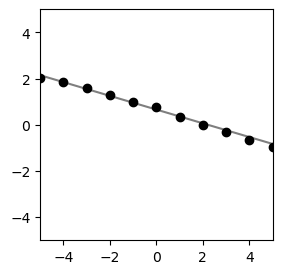

In [18]:
figure(figsize=(3,3))
render_trace(trace);

Because a generative function is stochastic, we need to visualize many runs in order to understand its behavior. The cell below renders a grid of traces.

In [19]:
function grid(renderer::Function, traces; ncols=6, nrows=3)
    figure(figsize=(16, 8))
    for (i, trace) in enumerate(traces)
        subplot(nrows, ncols, i)
        renderer(trace)
    end
end;

Now, we generate several traces and render them in a grid

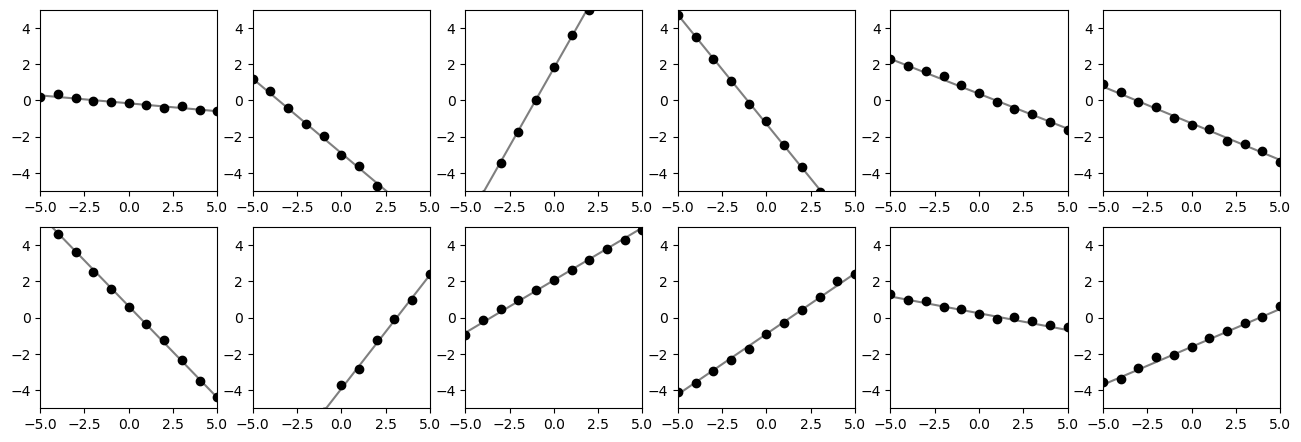

In [20]:
traces = [Gen.simulate(line_model, (xs,)) for _=1:12]
grid(render_trace, traces)

-------------------------------------------------
### Exercise

Write a generative function that uses the same address twice. Run it to see what happens.

In [21]:
@gen function line_model_bad(xs::Vector{Float64})
    n = length(xs)
    
    # We begin by sampling a slope and intercept for the line.
    # Before we have seen the data, we don't know the values of
    # these parameters, so we treat them as random choices. The
    # distributions they are drawn from represent our prior beliefs
    # about the parameters: in this case, that neither the slope nor the
    # intercept will be more than a couple points away from 0.
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :slope)
    
    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    for (i, x) in enumerate(xs)
        @trace(normal(slope * x + intercept, 0.1), (:y, i))
    end
    
    # The return value of the model is often not particularly important,
    # Here, we simply return n, the number of points.
    return n
end;

In [22]:
line_model_bad(xs)

ErrorException: Attempted to visit address slope, but it was already visited

### Solution

-------------------------------
### Exercise

Write a model that generates a sine wave with random phase, period and amplitude, and then generates y-coordinates from a given vector of x-coordinates by adding noise to the value of the wave at each x-coordinate.
Use a  `gamma(5, 1)` prior distribution for the period, and a `gamma(1, 1)` prior distribution on the amplitude (see [`Gen.gamma`](https://probcomp.github.io/Gen/dev/ref/distributions/#Gen.gamma)). Use a uniform distribution for the phase (see [`Gen.uniform`](https://probcomp.github.io/Gen/dev/ref/distributions/#Gen.uniform)). Write a function that renders the trace by showing the data set and the sine wave. Visualize a grid of traces and discuss the distribution. Try tweaking the parameters of each of the prior distributions and seeing how the behavior changes.

We have provided you with some starter code for the sine wave model:

### Solution

In [23]:
gamma(5,1)

4.256166267231681

In [24]:
@gen function sine_model(xs::Vector{Float64})
    n = length(xs)
 
    # < your code here >
    period = @trace(gamma(5,1),:period)
    amplitude = @trace(gamma(1,1),:amplitude)
    phase = @trace(uniform(0,period),:phase)
 
    for (i, x) in enumerate(xs)
        y = amplitude*sin(period*(x+phase))
        @trace(normal(y, 0.1), (:y, i))
    end
    return n
end;

In [25]:
trace = Gen.simulate(sine_model, (xs,));

In [26]:
println(trace[(:y,1)])

-0.26543043623467155


In [27]:
function render_sine_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    xmin = minimum(xs)
    xmax = maximum(xs)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    
    amplitude=trace[:amplitude]
    period=trace[:period]
    phase=trace[:phase]
    plot(collect(-5:0.01:5), amplitude *  map(sin,(period*(collect(-5:0.01:5) .+ phase))), color="black", alpha=0.5)

    
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

In [28]:
traces = [Gen.simulate(sine_model, (xs,)) for _=1:12];

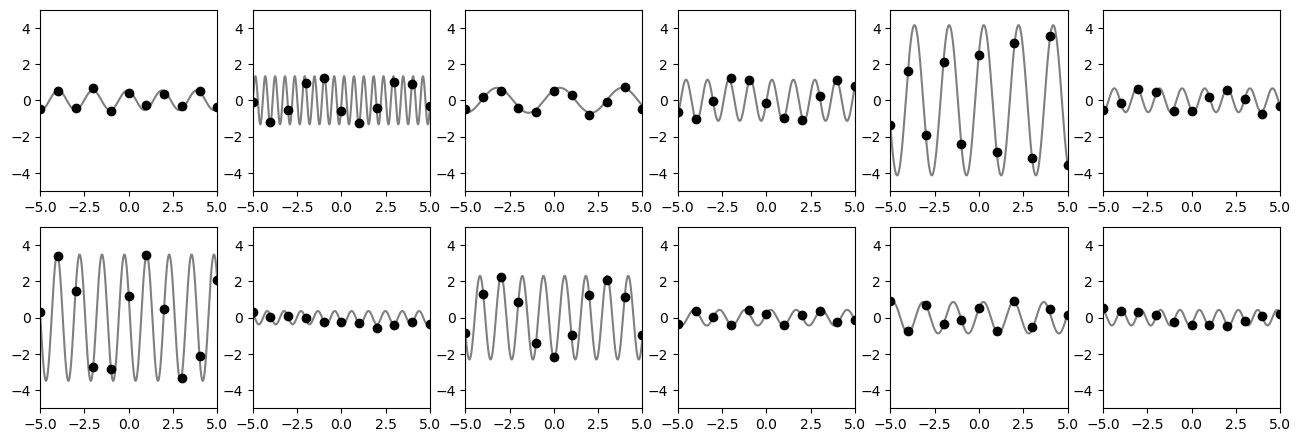

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render_sine_trace#9(::Bool, ::Function, ::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[27]:17
└ @ Main ./In[27]:17
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render_sine_trace#9(::Bool, ::Function, ::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[27]:18
└ @ Main ./In[27]:18


In [29]:
figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_sine_trace(trace)
end

## 3. Doing Posterior inference  <a name="doing-inference"></a>

We now will provide a data set of y-coordinates and try to draw inferences about the process that generated the data. We begin with the following data set:

In [30]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];

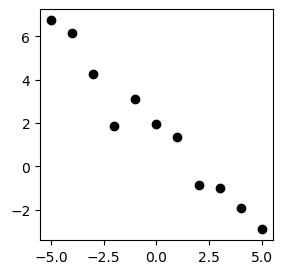

In [31]:
figure(figsize=(3,3))
scatter(xs, ys, color="black");

We will assume that the line model was responsible for generating the data, and infer values of the slope and intercept that explain the data.

To do this, we write a simple *inference program* that takes the model we are assuming generated our data, the data set, and the amount of computation to perform, and returns a trace of the function that is approximately sampled from the _posterior distribution_ on traces of the function, given the observed data. That is, the inference program will try to find a trace that well explains the dataset we created above. We can inspect that trace to find estimates of the slope and intercept of a line that fits the data.

Functions like `importance_resampling` expect us to provide a _model_ and also an _choice map_ representing our data set and relating it to the model. A choice map maps random choice addresses from the model to values from our data set. Here, we want to tie model addresses like `(:y, 4)` to data set values like `ys[4]`:

In [32]:
function do_inference(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

We can run the inference program to obtain a trace, and then visualize the result:

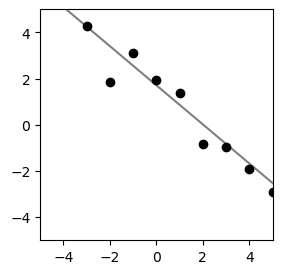

In [33]:
trace = do_inference(line_model, xs, ys, 100)
figure(figsize=(3,3))
render_trace(trace);

We see that `importance_resampling` found a reasonable slope and intercept to explain the data. We can also visualize many samples in a grid:

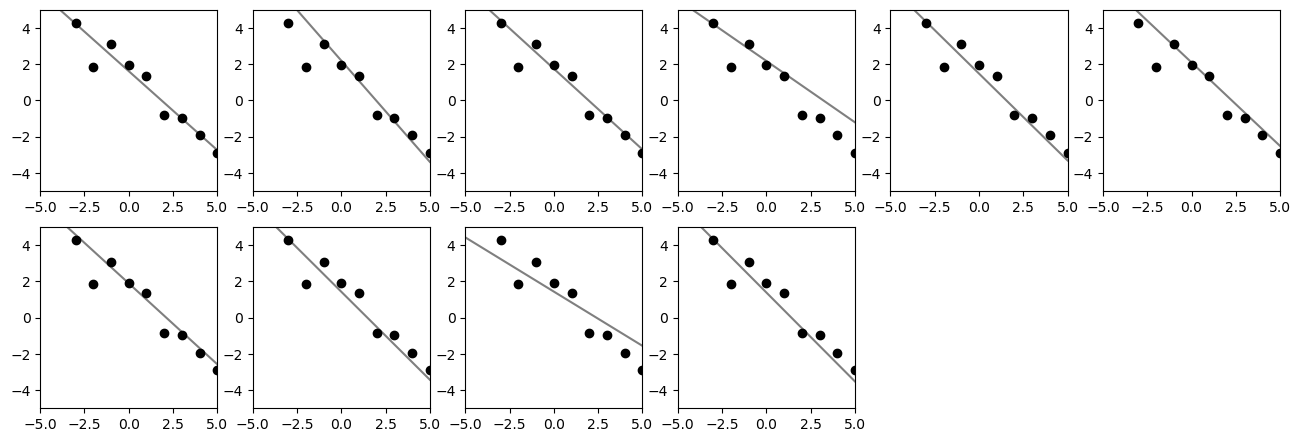

In [34]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
grid(render_trace, traces)

We can see here that there is some uncertainty: with our limited data, we can't be 100% sure exactly where the line is. We can get a better sense for the variability in the posterior distribution by visualizing all the traces in one plot, rather than in a grid. Each trace is going to have the same observed data points, so we only plot those once, based on the values in the first trace:

In [35]:
function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

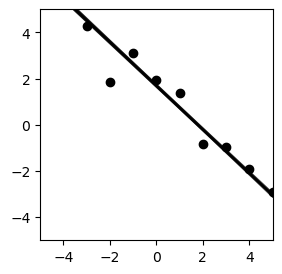

In [36]:
traces = [do_inference(line_model, xs, ys, 10000) for _=1:10];
figure(figsize=(3,3))
overlay(render_trace, traces);

--------------

### Exercise

The results above were obtained for `amount_of_computation = 100`. Run the algorithm with this value set to `1`, `10`, and `1000`, etc.  Which value seems like a good tradeoff between accuracy and running time? Discuss.

### Solution

------------------

### Exercise
Consider the following data set.

In [37]:
ys_sine = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];

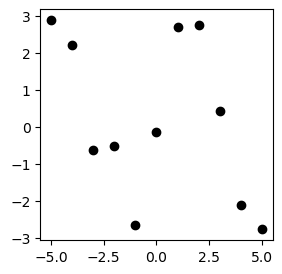

In [38]:
figure(figsize=(3, 3));
scatter(xs, ys_sine, color="black");

Write an inference program that generates traces of `sine_model` that explain this data set. Visualize the resulting distribution of traces. Temporarily change the prior distribution on the period to be `gamma(1, 1)`  (by changing and re-running the cell that defines `sine_model` from a previous exercise). Can you explain the difference in inference results when using `gamma(1, 1)` vs `gamma(5, 1)` prior on the period? How much computation did you need to get good results?

### Solution

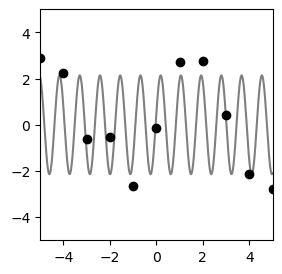

In [39]:
trace = do_inference(sine_model, xs, ys_sine, 1000)
figure(figsize=(3,3))
render_sine_trace(trace);

In [40]:
@gen function sine_model_alt(xs::Vector{Float64})
    n = length(xs)
 
    # < your code here >
    period = @trace(gamma(1,1),:period)
    amplitude = @trace(gamma(1,1),:amplitude)
    phase = @trace(uniform(0,period),:phase)
 
    for (i, x) in enumerate(xs)
        y = amplitude*sin(period*(x+phase))
        @trace(normal(y, 0.1), (:y, i))
    end
    return n
end;

In [41]:
trace = do_inference(sine_model_2, xs, ys_sine, 1000)
figure(figsize=(3,3))
render_sine_trace(trace);

UndefVarError: UndefVarError: sine_model_2 not defined

## 4. Predicting new data  <a name="predicting-data"></a>

Using the API method [`generate`](https://probcomp.github.io/Gen/dev/ref/gfi/#Gen.generate), we can generate a trace of a generative function in which the values of certain random choices are constrained to given values. The constraints are a choice map that maps the addresses of the constrained random choices to their desired values. 

For example:

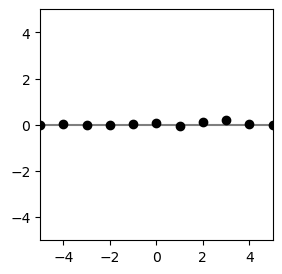

In [42]:
constraints = Gen.choicemap()
constraints[:slope] = 0.
constraints[:intercept] = 0.
(trace, _) = Gen.generate(line_model, (xs,), constraints)
figure(figsize=(3,3))
render_trace(trace);

Note that the random choices corresponding to the y-coordinates are still made randomly. Run the cell above a few times to verify this.

We will use the ability to run constrained executions of a generative function to predict the value of the y-coordinates at new x-coordinates by running new executions of the model generative function in which the random choices corresponding to the parameters have been constrained to their inferred values.  We have provided a function below (`predict_new_data`) that takes a trace, and a vector of new x-coordinates, and returns a vector of predicted y-coordinates corresponding to the x-coordinates in `new_xs`. We have designed this function to work with multiple models, so the set of parameter addresses is an argument (`param_addrs`):

In [43]:
function predict_new_data(model, trace, new_xs::Vector{Float64}, param_addrs)
    
    # Copy parameter values from the inferred trace (`trace`)
    # into a fresh set of constraints.
    constraints = Gen.choicemap()
    for addr in param_addrs
        constraints[addr] = trace[addr]
    end
    
    # Run the model with new x coordinates, and with parameters 
    # fixed to be the inferred values
    (new_trace, _) = Gen.generate(model, (new_xs,), constraints)
    
    # Pull out the y-values and return them
    ys = [new_trace[(:y, i)] for i=1:length(new_xs)]
    return ys
end;

The cell below defines a function that first performs inference on an observed data set `(xs, ys)`, and then runs `predict_new_data` to generate predicted y-coordinates. It repeats this process `num_traces` times, and returns a vector of the resulting y-coordinate vectors.

In [44]:
function infer_and_predict(model, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    pred_ys = []
    for i=1:num_traces
        trace = do_inference(model, xs, ys, amount_of_computation)
        push!(pred_ys, predict_new_data(model, trace, new_xs, param_addrs))
    end
    pred_ys
end;

Finally, we define a cell that plots the observed data set `(xs, ys)` as red dots, and the predicted data as small black dots.

In [45]:
function plot_predictions(xs, ys, new_xs, pred_ys)
    scatter(xs, ys, color="red")
    for pred_ys_single in pred_ys
        scatter(new_xs, pred_ys_single, color="black", s=1, alpha=0.3)
    end
end;

Recall the original dataset for the line model. The x-coordinates span the interval -5 to 5.

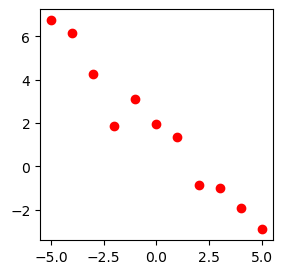

In [46]:
figure(figsize=(3,3))
scatter(xs, ys, color="red");

We will use the inferred values of the parameters to predict y-coordinates for x-coordinates in the interval 5 to 10 from which data was not observed. We will also predict new data within the interval -5 to 5, and we will compare this data to the original observed data. Predicting new data from inferred parameters, and comparing this new data to the observed data is the core idea behind *posterior predictive checking*. This tutorial does not intend to give a rigorous overview behind techniques for checking the quality of a model, but intends to give high-level intuition.

In [47]:
new_xs = collect(range(-5, stop=10, length=100));

We generate and plot the predicted data:

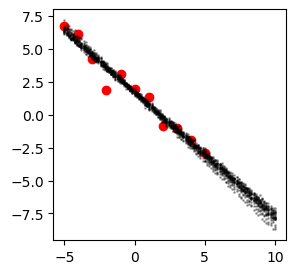

In [48]:
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys, new_xs, pred_ys)

The results look reasonable, both within the interval of observed data and in the extrapolated predictions on the right.

Now consider the same experiment run with following data set, which has significantly more noise.

In [49]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031];

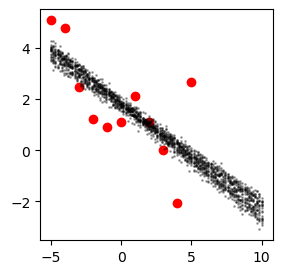

In [50]:
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

It looks like the generated data is less noisy than the observed data in the regime where data was observed, and it looks like the forecasted data is too overconfident. This is a sign that our model is mis-specified. In our case, this is because we have assumed that the noise has value 0.1. However, the actual noise in the data appears to be much larger. We can correct this by making the noise a random choice as well and inferring its value along with the other parameters.

We first write a new version of the line model that samples a random choice for the noise from a `gamma(1, 1)` prior distribution.

In [51]:
@gen function line_model_2(xs::Vector{Float64})
    n = length(xs)
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :intercept)
    noise = @trace(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @trace(normal(slope * x + intercept, noise), (:y, i))
    end
    return nothing
end;

Then, we compare the predictions using inference the unmodified and modified model on the `ys` data set:

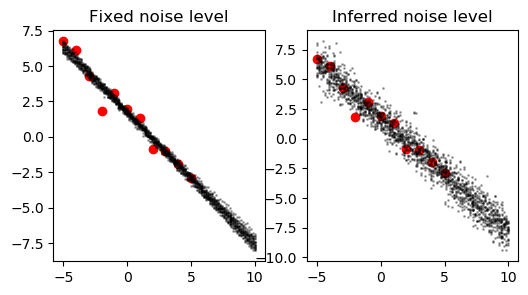

In [52]:
figure(figsize=(6,3))

pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ys, new_xs, pred_ys)

pred_ys = infer_and_predict(line_model_2, xs, ys, new_xs, [:slope, :intercept, :noise], 20, 10000)
subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ys, new_xs, pred_ys)

Notice that there is more uncertainty in the predictions made using the modified model.

We also compare the predictions using inference the unmodified and modified model on the `ys_noisy` data set:

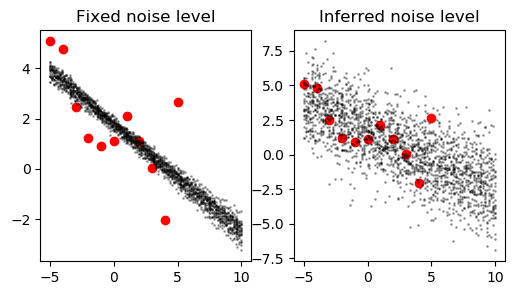

In [53]:
figure(figsize=(6,3))

pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

pred_ys = infer_and_predict(line_model_2, xs, ys_noisy, new_xs, [:slope, :intercept, :noise], 20, 10000)
subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

Notice that while the unmodified model was very overconfident, the modified model has an appropriate level of uncertainty, while still capturing the general negative trend.

-------------------------
### Exercise

Write a modified version the sine model that makes noise into a random choice. Compare the predicted data with the observed data `infer_and_predict` and `plot_predictions` for the unmodified and modified model, and for the `ys_sine` and `ys_noisy` datasets. Discuss the results. Experiment with the amount of inference computation used. The amount of inference computation will need to be higher for the model with the noise random choice.

We have provided you with starter code:

### Solution

In [54]:
@gen function sine_model_2(xs::Vector{Float64})
    n = length(xs)
    
    # < your code here >
    period = @trace(gamma(1,1),:period)
    amplitude = @trace(gamma(5,1),:amplitude)
    phase = @trace(uniform(0,period),:phase)
    noise = @trace(gamma(5, 1), :noise)
    
    for (i, x) in enumerate(xs)
        y = amplitude*sin(period*(x+phase))
        @trace(normal(y, noise), (:y, i))
#         @trace(normal(0., noise), (:y, i)) # < edit this line >
    end
    return n
end;

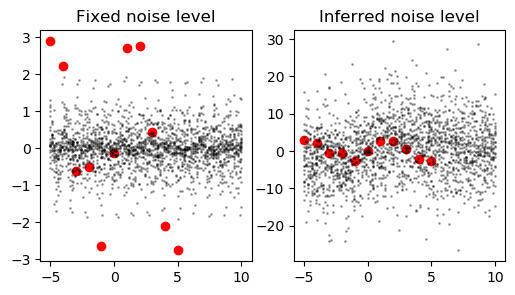

In [55]:
figure(figsize=(6,3))

# Modify the line below>
pred_ys = infer_and_predict(sine_model, xs, ys_sine, new_xs, [], 20, 10000)

subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ys_sine, new_xs, pred_ys)

# Modify the line below>
pred_ys = infer_and_predict(sine_model_2, xs, ys_sine, new_xs, [], 20, 10000)

subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ys_sine, new_xs, pred_ys)

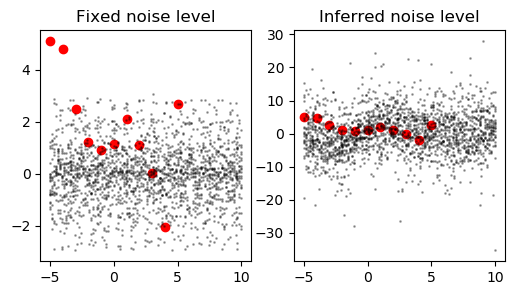

In [56]:
figure(figsize=(6,3))

# Modify the line below>
pred_ys = infer_and_predict(sine_model, xs, ys_noisy, new_xs, [], 20, 1)

subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

# Modify the line below>
pred_ys = infer_and_predict(sine_model_2, xs, ys_noisy, new_xs, [], 20, 1)

subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

## 5. Calling other generative functions  <a name="calling-functions"></a>

In addition to making random choices, generative functions can invoke other generative functions. To illustrate this, we will write a probabilistic model that combines the line model and the sine model. This model is able to explain data using either model, and which model is chosen will depend on the data. This is called *model selection*.

A generative function can invoke another generative function in three ways:

- using regular Julia function call syntax

- using the `@trace` Gen keyword with an address: `@trace(<call>, <addr>)`

- using the `@trace` Gen keyword without an address: `@trace(<call>)`

When invoking using regular function call syntax, the random choices made by the callee function are not traced. When invoking using `@trace` without an address, the random choices of the callee function are placed in the same address namespace as the caller's random choices. When using `@trace(<call>, <addr>)`, the random choices of the callee are placed under the namespace `<addr>`.

In [57]:
@gen function foo()
    @trace(normal(0, 1), :y)
end

@gen function bar()
    @trace(bernoulli(0.5), :x)
    @trace(foo())
end

@gen function bar_using_namespace()
    @trace(bernoulli(0.5), :x)
    @trace(foo(), :z)
end;

We first show the addresses sampled by `bar`:

In [58]:
trace = Gen.simulate(bar, ())
println(Gen.get_choices(trace))

│
├── :y : -0.9068077846586705
│
└── :x : false



And the addresses sampled by `bar_using_namespace`:

In [59]:
trace = Gen.simulate(bar_using_namespace, ())
println(Gen.get_choices(trace))

│
├── :x : false
│
└── :z
    │
    └── :y : -1.032306304824718



Using `@trace` with a namespace can help avoid address collisions for complex models.

A hierarchical address is represented as a Julia `Pair`, where the first element of the pair is the first element of the address and the second element of the pair is the rest of the address:

In [60]:
trace[Pair(:z, :y)]

-1.032306304824718

Julia uses the `=>` operator as a shorthand for the `Pair` constructor, so we can access choices at hierarchical addresses like:

In [61]:
trace[:z => :y]

-1.032306304824718

If we have a hierarchical address with more than two elements, we can construct the address by chaining the `=>` operator:

In [62]:
@gen function baz()
    @trace(bar_using_namespace(), :a)
end

trace = simulate(baz, ())

trace[:a => :z => :y]

0.4899090736619113

Note that the `=>` operator associated right, so this is equivalent to:

In [63]:
trace[Pair(:a, Pair(:z, :y))]

0.4899090736619113

Now, we write a generative function that combines the line and sine models. It makes a Bernoulli random choice (e.g. a coin flip that returns true or false) that determines which of the two models will generate the data.

In [64]:
@gen function combined_model(xs::Vector{Float64})
    if @trace(bernoulli(0.5), :is_line)
        @trace(line_model_2(xs))
    else
        @trace(sine_model_2(xs))
    end
end;

We also write a visualization for a trace of this function:

In [65]:
function render_combined(trace; show_data=true)
    if trace[:is_line]
        render_trace(trace, show_data=show_data)
    else
        render_sine_trace(trace, show_data=show_data)
    end
end;

We visualize some traces, and see that sometimes it samples linear data and other times sinusoidal data.

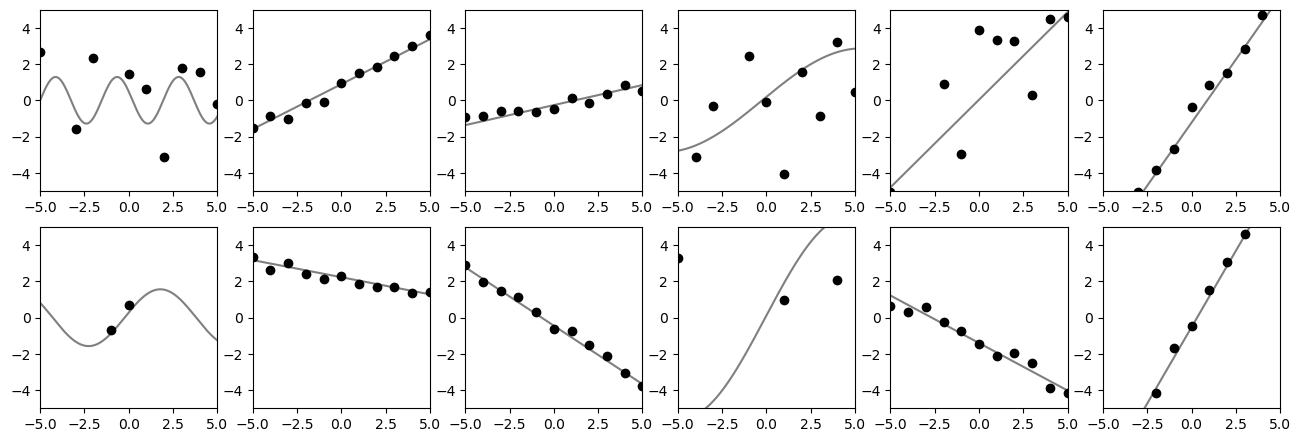

In [66]:
traces = [Gen.simulate(combined_model, (xs,)) for _=1:12];
grid(render_combined, traces)

We run inference using this combined model on the `ys` data set and the `ys_sine` data set. 

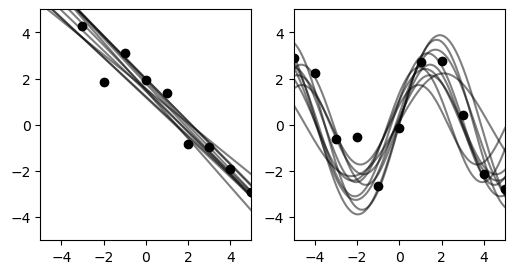

In [67]:
figure(figsize=(6,3))
subplot(1, 2, 1)
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
overlay(render_combined, traces)
subplot(1, 2, 2)
traces = [do_inference(combined_model, xs, ys_sine, 10000) for _=1:10];
overlay(render_combined, traces)

In [68]:
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];

In [69]:
# traces[1][:is_line]
length(filter(x->!x[:is_line],traces))

0

In [70]:
ambiguous_xs = xs[1:6]
ambiguous_ys = ys_sine[1:6]
traces = [do_inference(combined_model, ambiguous_xs, ambiguous_ys, 10000) for _=1:1000];


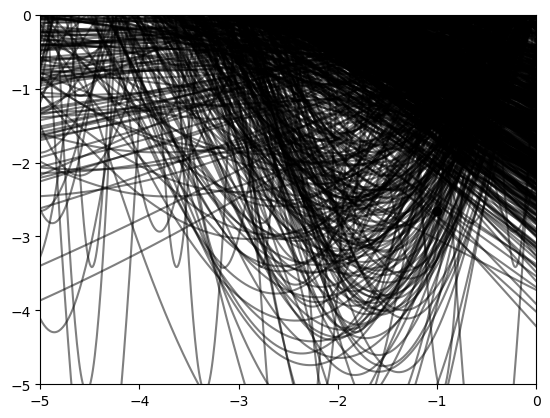

In [71]:
overlay(render_combined, traces)

In [72]:
length(filter(x->x[:is_line],traces))/length(traces)


0.743

The results should show that the line model was inferred for the `ys` data set, and the sine wave model was inferred for the `ys_sine` data set.

-------

### Exercise

Construct a data set for which it is ambiguous whether the line or sine wave model is best. Visualize the inferred traces using `render_combined` to illustrate the ambiguity. Write a program that takes the data set and returns an estimate of the posterior probability that the data was generated by the sine wave model, and run it on your data set.

Hint: To estimate the posterior probability that the data was generated by the sine wave model, run the inference program many times to compute a large number of traces, and then compute the fraction of those traces in which `:is_line` is false.

### Solution

------
### Exercise 

There is code that is duplicated between `line_model_2` and `sine_model_2`. Refactor the model to reduce code duplication and improve the readability of the code. Re-run the experiment above and confirm that the results are qualitatively the same. You may need to write a new rendering function. Try to avoid introducing code duplication between the model and the rendering code.

Hint: To avoid introducing code duplication between the model and the rendering code, use the return value of the generative function.

### Solution

In [73]:


# @gen function sine_model_2(xs::Vector{Float64})
#     n = length(xs)
    
#     # < your code here >
#     period = @trace(gamma(1,1),:period)
#     amplitude = @trace(gamma(5,1),:amplitude)
#     phase = @trace(uniform(0,period),:phase)
#     noise = @trace(gamma(1, 1), :noise)
    
#     for (i, x) in enumerate(xs)
#         y = amplitude*sin(period*(x+phase))
#         @trace(normal(y, noise), (:y, i))
# #         @trace(normal(0., noise), (:y, i)) # < edit this line >
#     end
#     return n
# end;

# @gen function line_model_2(xs::Vector{Float64})
#     n = length(xs)
#     slope = @trace(normal(0, 1), :slope)
#     intercept = @trace(normal(0, 2), :intercept)
#     noise = @trace(gamma(1, 1), :noise)
#     for (i, x) in enumerate(xs)
#         @trace(normal(slope * x + intercept, noise), (:y, i))
#     end
#     return nothing
# end;

In [74]:
@gen function noised(ps)

    noise = @trace(gamma(1, 1), :noise)
    for (i, p) in enumerate(ps)
        @trace(normal(p, noise), (:y, i))
    end
    
end;
    

@gen function line_model_refactored(xs::Int64)
#     show(4)
    
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :intercept)
    predictions = slope * xs .+ intercept
    return predictions
#     @trace(noised(predictions))
    # < your code here >
end;

In [75]:
@gen function sine_model_refactored(xs::Vector{Float64})
    period = @trace(gamma(1,1),:period)
    amplitude = @trace(gamma(5,1),:amplitude)
    phase = @trace(uniform(0,period),:phase)
    predictions = amplitude *  map(sin,(period*xs .+ phase))
#     noise = @trace(gamma(1, 1), :noise)
    return predictions
    # < your code here >
end;

In [76]:
@gen function combined_model_refactored(xs::Vector{Float64})
    if @trace(bernoulli(0.5), :is_line)
        predictions = @trace(line_model_refactored(xs))
    else
        predictions = @trace(sine_model_refactored(xs))
    end
    out = @trace(noised(predictions))
    # < your code here >
end;

In [77]:
function render_combined_refactored(trace; show_data=true)
    xs = Gen.get_args(trace)[1]
    xmin = minimum(xs)
    xmax = maximum(xs)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
#         ymin = minimum(ys)
#         ymax = maximum(ys)
        scatter(xs, ys, c="black")
    end

    if trace[:is_line]
        slope = trace[:slope]
        intercept = trace[:intercept]
        plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    else        
        amplitude=trace[:amplitude]
        period=trace[:period]
        phase=trace[:phase]
        plot(collect(-5:0.01:5), amplitude *  map(sin,(period*(collect(-5:0.01:5) .+ phase))), color="black", alpha=0.5)
    end
    # < your code here >
#     traces = [do_inference(line_model, xs, ys, 10000) for _=1:10];
#     figure(figsize=(3,3))
#     overlay(render_trace, traces);
    
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;


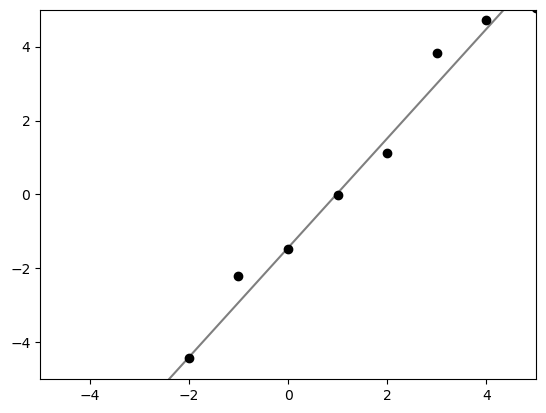

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render_combined_refactored#36(::Bool, ::Function, ::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[77]:28
└ @ Main ./In[77]:28
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render_combined_refactored#36(::Bool, ::Function, ::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[77]:29
└ @ Main ./In[77]:29


(-5.0, 5.0)

In [78]:
# show(typeof(xs))
# show(xs)
# xs = [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
# show(typeof(line_model_refactored))
# show(line_model_refactored(xs))
trace = simulate(combined_model_refactored,(xs,))
render_combined_refactored(trace)

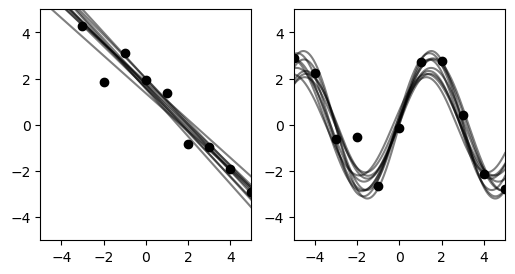

In [79]:
figure(figsize=(6,3))
subplot(1, 2, 1)
traces = [do_inference(combined_model_refactored, xs, ys, 10000) for _=1:10];
overlay(render_combined_refactored, traces)

subplot(1, 2, 2)
traces = [do_inference(combined_model_refactored, xs, ys_sine, 10000) for _=1:10];
overlay(render_combined_refactored, traces)

## 6. Modeling with an unbounded number of parameters  <a name="infinite-space"></a>

Gen's built-in modeling language can be used to express models that use an unbounded number of parameters. This section walks you through development of a model of data that does not a-priori specify an upper bound on the complexity of the model, but instead infers the complexity of the model as well as the parameters. This is a simple example of a *Bayesian nonparametric* model.

We will consider two data sets:

In [80]:
xs_dense = collect(range(-5, stop=5, length=50))
ys_simple = fill(1., length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_complex = [Int(floor(abs(x/3))) % 2 == 0 ? 2 : 0 for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[81]:6
└ @ Core In[81]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[81]:11
└ @ Core In[81]:11


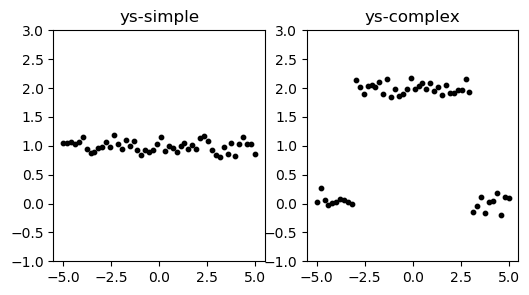

(-1, 3)

In [81]:
figure(figsize=(6,3))

subplot(1, 2, 1)
title("ys-simple")
scatter(xs_dense, ys_simple, color="black", s=10)
gca()[:set_ylim]((-1, 3))

subplot(1, 2, 2)
title("ys-complex")
scatter(xs_dense, ys_complex, color="black", s=10)
gca()[:set_ylim]((-1, 3))

The data set on the left appears to be best explained as a contant function with some noise. The data set on the right appears to include two changepoints, with a constant function in between the changepoints. We want a model that does not a-priori choose the number of changepoints in the data. To do this, we will recursively partition the interval into regions. We define a Julia data structure that represents a binary tree of intervals; each leaf node represents a region in which the function is constant.

In [82]:
struct Interval
    l::Float64
    u::Float64
end

In [83]:
abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

We now write a generative function that randomly creates such a tree. Note the use of recursion in this function to create arbitrarily large trees representing arbitrarily many changepoints. Also note that we assign the address namespaces `:left` and `:right` to the calls made for the two recursive calls to `generate_segments`.

In [84]:
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if @trace(bernoulli(0.7), :isleaf)
        value = @trace(normal(0, 1), :value)
        return LeafNode(value, interval)
    else
        frac = @trace(beta(2, 2), :frac)
        mid  = l + (u - l) * frac
        left = @trace(generate_segments(l, mid), :left)
        right = @trace(generate_segments(mid, u), :right)
        return InternalNode(left, right, interval)
    end
end;

We also define some helper functions to visualize traces of the `generate_segments` function.

In [85]:
function render_node(node::LeafNode)
    plot([node.interval.l, node.interval.u], [node.value, node.value])
end

function render_node(node::InternalNode)
    render_node(node.left)
    render_node(node.right)
end;

In [86]:
function render_segments_trace(trace)
    node = get_retval(trace)
    render_node(node)
    ax = gca()
    ax[:set_xlim]((0, 1))
    ax[:set_ylim]((-3, 3))
end;

We generate 12 traces from this function and visualize them below. We plot the piecewise constant function that was sampled by each run of the generative function. Different constant segments are shown in different colors. Run the cell a few times to get a better sense of the distribution on functions that is represented by the generative function.

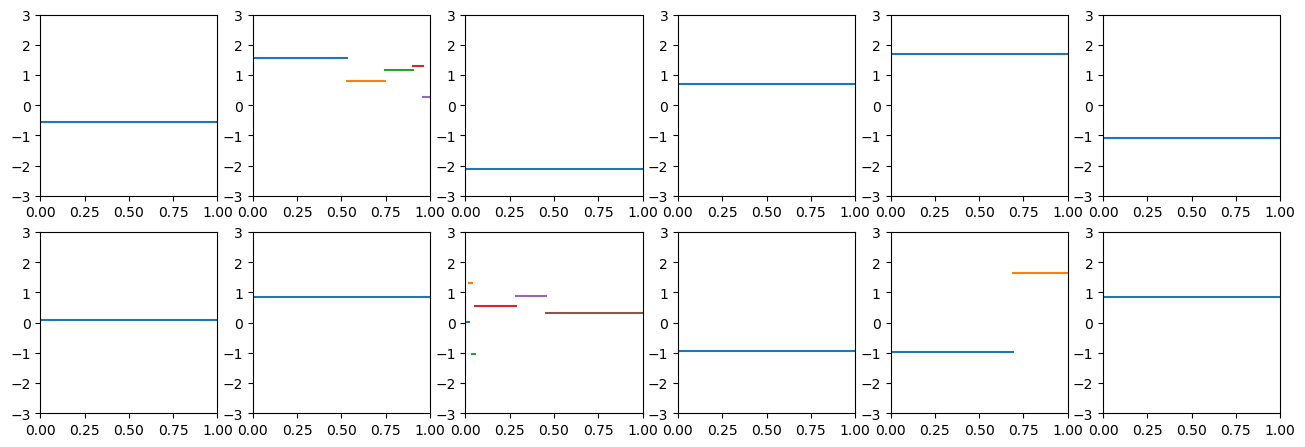

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_segments_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[86]:5
└ @ Main ./In[86]:5
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_segments_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[86]:6
└ @ Main ./In[86]:6


In [87]:
traces = [Gen.simulate(generate_segments, (0., 1.)) for i=1:12]
grid(render_segments_trace, traces)

Because we only sub-divide an interval with 30% probability, most of these sampled traces have only one segment.

Now that we have generative function that generates a random piecewise-constant function, we write a model that adds noise to the resulting constant functions to generate a data set of y-coordinates. The noise level will be a random choice.

In [88]:
# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(x::Float64, node::LeafNode)
    @assert x >= node.interval.l && x <= node.interval.u
    return node.value
end

function get_value_at(x::Float64, node::InternalNode)
    @assert x >= node.interval.l && x <= node.interval.u
    if x <= node.left.interval.u
        get_value_at(x, node.left)
    else
        get_value_at(x, node.right)
    end
end

# Out full model
@gen function changepoint_model(xs::Vector{Float64})
    node = @trace(generate_segments(minimum(xs), maximum(xs)), :tree)
    noise = @trace(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @trace(normal(get_value_at(x, node), noise), (:y, i))
    end
    return node
end;

We write a visualization for `changepoint_model` below:

In [89]:
function render_changepoint_model_trace(trace; show_data=true)
    xs = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    render_node(node)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    ax = gca()
    ax[:set_xlim]((minimum(xs), maximum(xs)))
    ax[:set_ylim]((-3, 3))
end;

Finally, we generate some simulated data sets and visualize them on top of the underlying piecewise constant function from which they were generated:

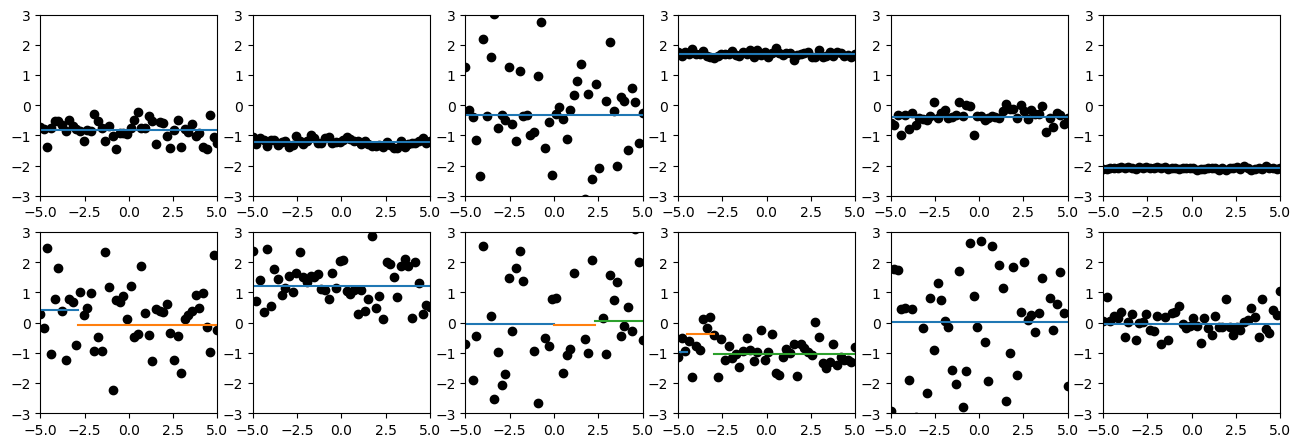

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render_changepoint_model_trace#47(::Bool, ::Function, ::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[89]:10
└ @ Main ./In[89]:10
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render_changepoint_model_trace#47(::Bool, ::Function, ::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[89]:11
└ @ Main ./In[89]:11


In [90]:
traces = [Gen.simulate(changepoint_model, (xs_dense,)) for i=1:12]
grid(render_changepoint_model_trace, traces)

Notice that the amount of variability around the piecewise constant mean function differs from trace to trace.

Now we perform inference for the simple data set:

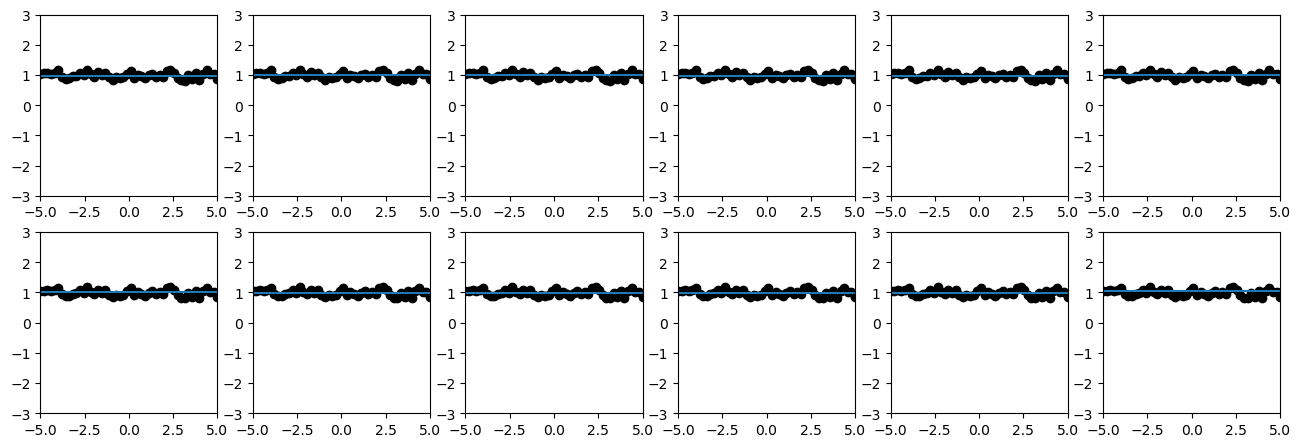

In [91]:
traces = [do_inference(changepoint_model, xs_dense, ys_simple, 10000) for _=1:12];
grid(render_changepoint_model_trace, traces)

We see that we inferred that the mean function that explains the data is a constant with very high probability.

For inference about the complex data set, we use more computation. You can experiment with different amounts of computation to see how the quality of the inferences degrade with less computation. Note that we are using a very simple generic inference algorithm in this tutorial, which really isn't suited for this more complex task. In later tutorials, we will learn how to write more efficient algorithms, so that accurate results can be obtained with significantly less computation. We will also see ways of annotating the model for better performance, no matter the inference algorithm.

In [127]:
traces = [do_inference(changepoint_model, xs_dense, ys_complex, 1000) for _=1:20];
grid(render_changepoint_model_trace, traces)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /Users/reuben/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('num must be 1 <= num <= 18, not 19')
  File "/Users/reuben/.julia/conda/3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 1076, in subplot
    a = fig.add_subplot(*args, **kwargs)
  File "/Users/reuben/.julia/conda/3/lib/python3.7/site-packages/matplotlib/figure.py", line 1414, in add_subplot
    a = subplot_class_factory(projection_class)(self, *args, **kwargs)
  File "/Users/reuben/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_subplots.py", line 59, in __init__
    f"num must be 1 <= num <= {rows*cols}, not {num}")


The results show that more segments are inferred for the more complex data set.

------
### Exercise
Write a function that takes a data set of x- and y-coordinates and plots the histogram of the probability distribution on the number of changepoints.
Show the results for the `ys_simple` and `ys_complex` data sets.

Hint: The return value of `changepoint_model` is the tree of `Node` values. Walk this tree.

### Solution

In [105]:
trace = do_inference(changepoint_model, xs_dense, ys_complex, 1000)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,1}], ##changepoint_model#475, Bool[false], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}((:y, 22)=>ChoiceOrCallRecord{Float64}(1.86547, -0.586082, NaN, true),(:y, 20)=>ChoiceOrCallRecord{Float64}(1.84146, -0.589081, NaN, true),(:y, 37)=>ChoiceOrCallRecord{Float64}(1.96691, -0.585854, NaN, true),(:y, 3)=>ChoiceOrCallRecord{Float64}(0.0531566, -0.590337, NaN, true),(:y, 6)=>ChoiceOrCallRecord{Float64}(0.0344843, -0.587613, NaN, true),(:y, 29)=>ChoiceOrCallRecord{Float64}(1.97659, -0.586884, NaN, true),(:y, 33)=>ChoiceOrCallRecord{Float64}(1.87586, -0.585133, NaN, true),(:y, 46)=>ChoiceOrCallRecord{Float64}(0.0502748, -3.99293, NaN, true),:noise=>ChoiceOrCallRecord{Float64}(0.714989, -0.714989, NaN, true),(:y, 36)=>ChoiceOrCallRecord{Float64}(1.91737, -0.583451, NaN, true)…), Dict{Any,Trie{Any,Gen.ChoiceOrCallRecord}}()), false, -72.19

In [121]:
# render_node(get_retval(trace))
node = get_retval(trace)
    
function count(node::LeafNode)
    return 1
end

function count(node::InternalNode)
    return count(node.left)+count(node.right)
end;
    
print(count(node))

2

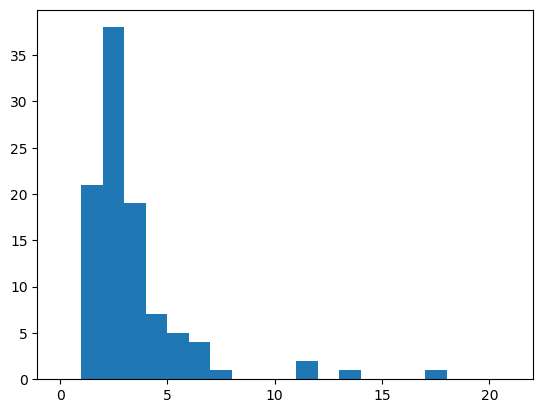

┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = top-level scope at In[125]:1
└ @ Core In[125]:1


([0.0, 21.0, 38.0, 19.0, 7.0, 5.0, 4.0, 1.0, 0.0, 0.0  …  2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  12, 13, 14, 15, 16, 17, 18, 19, 20, 21], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x16adc5400>, PyObject <matplotlib.patches.Rectangle object at 0x169794d68>, PyObject <matplotlib.patches.Rectangle object at 0x16adc5940>, PyObject <matplotlib.patches.Rectangle object at 0x16a23fe80>, PyObject <matplotlib.patches.Rectangle object at 0x16a23fbe0>, PyObject <matplotlib.patches.Rectangle object at 0x16a23f550>, PyObject <matplotlib.patches.Rectangle object at 0x16a23f630>, PyObject <matplotlib.patches.Rectangle object at 0x16a23f828>, PyObject <matplotlib.patches.Rectangle object at 0x16ae24ef0>, PyObject <matplotlib.patches.Rectangle object at 0x16ae24128>  …  PyObject <matplotlib.patches.Rectangle object at 0x16ae24860>, PyObject <matplotlib.patches.Rectangle object at 0x16ae24390>, PyObject <matplotlib.patches.Rectangle ob

In [125]:
bins = collect(range(0, 21))
hist([count(get_retval(do_inference(changepoint_model, xs_dense, ys_complex, 1000))) for _=1:100], bins=bins)

-------

### Exercise
Write a new version of `changepoint_model` that uses `@trace` without an address (e.g. `@trace(<call>)`) to make the recursive calls.

Hint: You will need to guarantee that all addresses are unique. How can you label each node in a binary tree using an integer?

### Solution